# Review of classical electronic structure methods 

In order to assess the performance of quantum computing algorithms in addressing the electronic structure problem, we will briefly review a few commonly employed classical electronic structure methods of varying level of approximation. 

## Hartree-Fock

The Hartree-Fock (HF) method employs a **mean-field approximation**, where Coulomb correlation of electrons is neglected. The HF wavefunction is hence restricted to the form of a single Slater determinant, for which the optimal form may be acquired by an optimization of the underlying single particle basis (orbitals). Once the optimal HF orbitals have been found, the HF state may be written as 

$$ | \text{HF} \rangle = \prod_{p \in \text{occ}} \hat a^\dagger_p | \text{vac} \rangle $$

where $\hat a^\dagger_p$ creates an electron in the $p^{\rm{th}}$ optimized HF spin orbital, and  $| \text{vac} \rangle$ is the vacuum state (all spin-orbitals unoccupied). Due to the restriction to a single Slater determinant, the HF energy may be obtained very efficiently and can be applied to very large molecules, however it becomes qualitatively incorrect when **electronic correlations** become sufficiently strong. The HF wavefunction is often used as a starting point in more accurate treatments of electronic correlation. 

## Coupled cluster

The Coupled cluster (CC) method introduces electronic correlation to the wavefunction ansatz by operating on the HF reference state with the exponential of excitation operators

$$|\text{CC} \rangle = e^{\hat T} | \text{HF}\rangle, \quad \hat T = \hat T_1 + \hat T_2 + ...$$

where $\hat T_1 = \sum_{ia} t^{a}_i \hat a^\dagger_a \hat a_i$ are referred to as 'singles', $\hat T_2 = \sum_{ijab} t^{ab}_{ij} \hat a^\dagger_a \hat a^\dagger_b \hat a_i \hat a_j$ as 'doubles', etc. When the excitation rank is truncated to only singles (S) and doubles (D), $\hat T = \hat T_1 + \hat T_2$, the corresponding ansatz is referred to as CCSD. Since the number of possible single and double excitations for a system of $N$ electrons in $M$ orbitals is polynomial in $M$, one can efficiently solve a system of equations to obtain the optimized CCSD amplitudes. CCSD often gives accurate energies and can be applied to modestly sized chemical systems. However, due to its implementation, it can **violate the variational principle** and give energies lower than the ground state.

## Full Configuration Interaction
The full configuration interaction (FCI) method yields the **exact ground state energy** within a given basis set. The FCI wavefunction is written as a linear combination of all possible $N$-particle Slater determinants over the orbital basis
$$|\text{FCI} \rangle =  \left( \sum_{ia} C^{a}_i \hat a^\dagger_a \hat a_i + \sum_{ijab} C^{ab}_{ij} \hat a^\dagger_a \hat a^\dagger_b \hat a_i \hat a_j + ...  \right) | \text{HF} \rangle $$
where the sum includes up to $N$-electron excitations, and hence there are an exponential number of coefficients to optimize in $| \text{FCI} \rangle$. Due to its **exponential complexity**, FCI is often reserved for only the smallest chemical systems. However, it serves as a useful result to compare to when assessing tractable electronic structure methods.

# Benchmarking for electronic PESs in minimal basis (STO-3G)

We will apply HF, CCSD, and FCI to obtaining the PESs for a few molecular dissociation processes in minimal (STO-3G) basis.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from utility import get_molecular_data, obtain_PES
import time
import pandas as pd

/home/abarthe/.local/lib/python3.7/site-packages/pyscf/lib/misc.py:46: H5pyDeprecationWarning: Using default_file_mode other than 'r' is deprecated. Pass the mode to h5py.File() instead.
  h5py.get_config().default_file_mode = 'a'


In [2]:
class benchmark:
    def __init__(self,list_molecules=['h2'], list_basis=['sto-3g'], list_methods=['fci'],bond_lengths = np.linspace(0.2,2.6,15)):
        self.list_molecules = list_molecules
        self.list_basis = list_basis
        self.list_methods = list_methods
        self.bond_lengths = bond_lengths
        
        self.times = np.zeros((len(list_molecules),len(list_basis),len(list_methods)))
        self.results=np.zeros((len(list_molecules),len(list_basis),len(list_methods),len(bond_lengths)))
    
    def compute_all(self):
        for i_m,m in enumerate(self.list_molecules):
            print(f'{i_m+1} molecule out of {len(self.list_molecules)}')
            for i_b,b in enumerate(self.list_basis):
                print(f'{i_b+1} basis out of {len(self.list_basis)}')
                for i_f,f in enumerate(self.list_methods):
                    print(f'{i_f+1} method out of {len(self.list_methods)}')
                    tic = time.time()
                    self.results[i_m,i_b,i_f,:] = obtain_PES([m], self.bond_lengths, b, method=f)
                    toc = time.time()
                    self.times[i_m,i_b,i_f]= toc-tic                   
            
    
    def plot_all(self,i_b):
        
        colors = ['orange','purple','yellow','green']
        N = len(self.list_molecules)
        L = 3
        K = int(N/L) + 1 

        fig, axs = plt.subplots(K, L,figsize=(15,5))

        for i_m in range(N):
            ax = axs[i_m]

            ax.plot(self.bond_lengths, self.results[i_m,i_b,0,:], label=self.list_methods[0],color='k')
            s=15 
            for i_f in range(1,len(self.list_methods)):
                ax.scatter(self.bond_lengths, self.results[i_m,i_b,i_f,:], label=self.list_methods[i_f], color=colors[i_f-1],s=s)
                s*=0.9

            ax.set_title(f'{self.list_molecules[i_m]} dissociation, {self.list_basis[i_b]}')
            ax.set_xlabel('R, Angstrom')
            ax.set_ylabel('E, Hartree')
            ax.legend()
    
    def print_times(self,i_b):
        print('Duration of computation in seconds')
        T = np.squeeze(self.times[:,i_b,:])
        df = pd.DataFrame(T, index =self.list_molecules,columns =self.list_methods)
        return df
    

# Benchmark Methods against Molecules

In [3]:
list_methods=['fci','hf','ccsd','cisd']
list_basis =['sto-3g','cc-pVDZ','cc-pVDZ','cc-pVTZ','cc-pVQZ','cc-pV5Z']
list_molecules=['h2','h2o','h4','lih','nh3','n2']

In [4]:
# list_methods[:-1]

In [5]:
# bench = benchmark(list_molecules=['h2','lih'],list_methods=['fci','hf'])
bench = benchmark(list_molecules=list_molecules,list_methods=list_methods[:-1])

In [ ]:
bench.compute_all()

1 molecule out of 6
1 basis out of 1
1 method out of 3
2 method out of 3
3 method out of 3
2 molecule out of 6
1 basis out of 1
1 method out of 3
2 method out of 3
3 method out of 3


In [ ]:
import pickle
with open('bench_molecules.pickle', 'wb') as f:
    pickle.dump(bench, f)

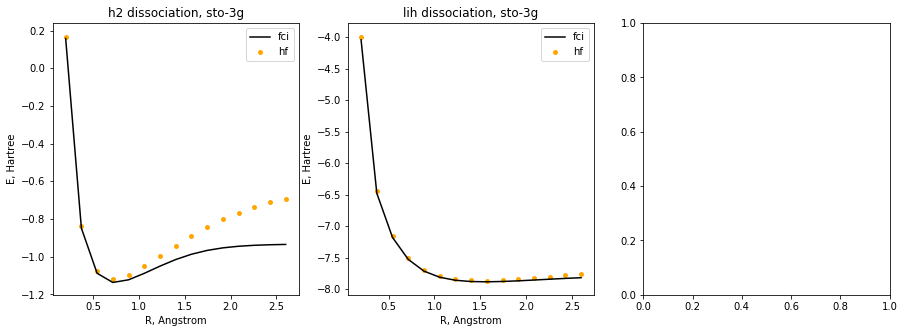

In [7]:
bench.plot_all(0)

In [8]:
bench.print_times(0)

,fci,hf
h2,10.856712,16.130583
lih,10.727693,18.968600


# one by one

In [6]:
basis = 'sto-3g'

In [2]:
bond_lengths = np.linspace(0.2,2.6,15)

## H<sub>2</sub>

In [8]:
#Run FCI
FCI_PES = obtain_PES(['h2'], bond_lengths, basis, method='fci')

E = 0.15748213365503272 Eh
E = -0.8488991062024303 Eh
E = -1.0882281844069168 Eh
E = -1.136928959400571 Eh
E = -1.1229570527982327 Eh
E = -1.0887645364963472 Eh
E = -1.050442037218747 Eh
E = -1.0154682491653277 Eh
E = -0.987392996293216 Eh
E = -0.9670259116093083 Eh
E = -0.9534242125062942 Eh
E = -0.9449089870950516 Eh
E = -0.9398197912188275 Eh
E = -0.9368706035283361 Eh
E = -0.9351960308386078 Eh


In [9]:
#Run HF
HF_PES = obtain_PES(['h2'], bond_lengths, basis,  method='hf')

E = 0.16412595411335862 Eh
E = -0.8397057843499789 Eh
E = -1.074887931719117 Eh
E = -1.1175258568986912 Eh
E = -1.0951595815644795 Eh
E = -1.0495617842752072 Eh
E = -0.9960202460350677 Eh
E = -0.9415475409906814 Eh
E = -0.8899750208893146 Eh
E = -0.8432718025417755 Eh
E = -0.8022428650141384 Eh
E = -0.7669825247359998 Eh
E = -0.7371545448988288 Eh
E = -0.7121961606082431 Eh
E = -0.6914700512624794 Eh


In [10]:
#Run CCSD
CCSD_PES = obtain_PES(['h2'], bond_lengths, basis,  method='ccsd')

E = 0.15748412056436217 Eh
E = -0.8488985094851161 Eh
E = -1.0882310174307857 Eh
E = -1.1369333351418656 Eh
E = -1.1229593878059763 Eh
E = -1.0887606905920533 Eh
E = -1.050426089327126 Eh
E = -1.015441636439638 Eh
E = -0.9873692257052735 Eh
E = -0.9670168314563374 Eh
E = -0.9534301294889956 Eh
E = -0.9449225613845066 Eh
E = -0.9398332746700124 Eh
E = -0.9368793989542732 Eh
E = -0.9351989265367034 Eh


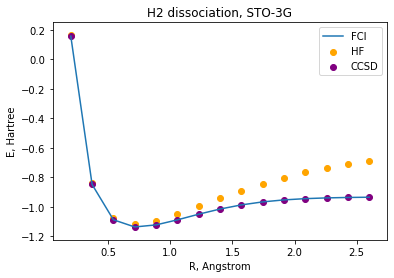

In [11]:
#Plot H2 PESs

plt.title('H2 dissociation, STO-3G')
plt.xlabel('R, Angstrom')
plt.ylabel('E, Hartree')

plt.plot(bond_lengths, FCI_PES, label='FCI')
plt.scatter(bond_lengths, HF_PES, label='HF', color='orange')
plt.scatter(bond_lengths, CCSD_PES, label='CCSD', color='purple')
plt.legend()

# two H2 far away

In [2]:
bond_lengths = np.linspace(0.2,2.6,15)

In [3]:
#Run FCI
method='fci'
FCI_PES_far_020 = obtain_PES(['h2farh2', 20], bond_lengths, basis, method=method)
FCI_PES_far_050 = obtain_PES(['h2farh2', 50], bond_lengths, basis, method=method)
FCI_PES_far_100 = obtain_PES(['h2farh2',100], bond_lengths, basis, method=method)

E = 0.3149642670630426 Eh
E = -1.6977982125337805 Eh
E = -2.1764563672960966 Eh
E = -2.273857914853844 Eh
E = -2.2459140984905015 Eh
E = -2.1775290631429867 Eh
E = -2.100884063486812 Eh
E = -2.030936488242109 Eh
E = -1.974786103304678 Eh
E = -1.9340518182378508 Eh
E = -1.9068484749648489 Eh
E = -1.8898179728208233 Eh
E = -1.8796395818245855 Eh
E = -1.873741206806981 Eh
E = -1.8703920615813012 Eh
E = 0.31496426730945704 Eh
E = -1.697798212655953 Eh
E = -2.1764563687298324 Eh
E = -2.27385791874977 Eh
E = -2.2459141055043865 Eh
E = -2.177529072841211 Eh
E = -2.1008840743116 Eh
E = -2.0309364981914246 Eh
E = -1.9747861109189886 Eh
E = -1.9340518231565338 Eh
E = -1.9068484777038046 Eh
E = -1.8898179741697305 Eh
E = -1.8796395824261836 Eh
E = -1.8737412070541009 Eh
E = -1.8703920616757173 Eh
E = 0.31496426730968885 Eh
E = -1.6977982126597695 Eh
E = -2.176456368749504 Eh
E = -2.2738579187993957 Eh
E = -2.245914105593351 Eh
E = -2.177529072966175 Eh
E = -2.1008840744543087 Eh
E = -2.0309364983

In [4]:
#Run HF
method='hf'
HF_PES_far_020 = obtain_PES(['h2farh2', 20], bond_lengths, basis, method=method)
HF_PES_far_050 = obtain_PES(['h2farh2', 50], bond_lengths, basis, method=method)
HF_PES_far_100 = obtain_PES(['h2farh2',100], bond_lengths, basis, method=method)

E = 0.32825049405101714 Eh
E = -1.6794123494164812 Eh
E = -2.1497765180862975 Eh
E = -2.2350522683756817 Eh
E = -2.190319707464405 Eh
E = -2.099124171848145 Eh
E = -1.9920410808130802 Eh
E = -1.8830955191472194 Eh
E = -1.7799505408843477 Eh
E = -1.686543729618704 Eh
E = -1.6044859594105518 Eh
E = -1.5339650498708477 Eh
E = -1.4743090770590241 Eh
E = -1.4243923141911403 Eh
E = -1.3829401105018104 Eh
E = 0.32825133878853996 Eh
E = -1.679411886232673 Eh
E = -2.1497761355164013 Eh
E = -2.235051946420054 Eh
E = -2.1903193922029787 Eh
E = -2.0991238234803484 Eh
E = -1.9920407430699816 Eh
E = -1.883095271487341 Eh
E = -1.7799503989939933 Eh
E = -1.686543665254923 Eh
E = -1.6044859421448534 Eh
E = -1.5339650561347193 Eh
E = -1.4743090898410647 Eh
E = -1.424392322719148 Eh
E = -1.3829401096015879 Eh
E = 0.3282516215123681 Eh
E = -1.6794117290585577 Eh
E = -2.149776001228355 Eh
E = -2.235051831808862 Eh
E = -2.190319279391405 Eh
E = -2.0991236980311676 Eh
E = -1.9920406197583236 Eh
E = -1.883095

In [5]:
#Run CCSD
method='ccsd'
CCSD_PES_far_020 = obtain_PES(['h2farh2', 20], bond_lengths, basis, method=method)
CCSD_PES_far_050 = obtain_PES(['h2farh2', 50], bond_lengths, basis, method=method)
CCSD_PES_far_100 = obtain_PES(['h2farh2',100], bond_lengths, basis, method=method)

E = 0.31496823861671736 Eh
E = -1.6977970271850853 Eh
E = -2.176462044946282 Eh
E = -2.2738666644310226 Eh
E = -2.2459187308647097 Eh
E = -2.1775212659513787 Eh
E = -2.1008519870069993 Eh
E = -2.0308830497907544 Eh
E = -1.974738350318297 Eh
E = -1.9340334834816004 Eh
E = -1.9068601882000957 Eh
E = -1.8898450775173194 Eh
E = -1.8796665473130618 Eh
E = -1.8737588142592698 Eh
E = -1.8703978713672345 Eh
E = 0.3149682401643466 Eh
E = -1.6977970228930863 Eh
E = -2.176462039952853 Eh
E = -2.2738666702372075 Eh
E = -2.2459187611268807 Eh
E = -2.1775213374505342 Eh
E = -2.1008521039376404 Eh
E = -2.0308831893813393 Eh
E = -1.974738480265767 Eh
E = -1.934033586556999 Eh
E = -1.9068602507824013 Eh
E = -1.8898451043967195 Eh
E = -1.8796665486537922 Eh
E = -1.8737588037667 Eh
E = -1.8703978602966478 Eh
E = 0.3149682406315429 Eh
E = -1.697797021197196 Eh
E = -2.1764620374845207 Eh
E = -2.273866670358621 Eh
E = -2.245918768364298 Eh
E = -2.1775213598495515 Eh
E = -2.1008521406909715 Eh
E = -2.0308832

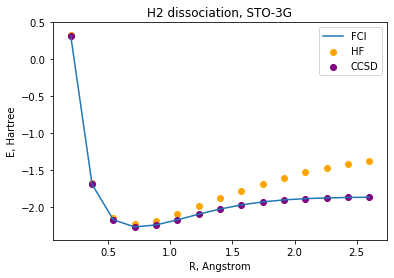

In [6]:
#Plot H2 PESs

plt.title('H2 dissociation, STO-3G')
plt.xlabel('R, Angstrom')
plt.ylabel('E, Hartree')

plt.plot(bond_lengths, FCI_PES_far_100, label='FCI')
plt.scatter(bond_lengths, HF_PES_far_100, label='HF', color='orange')
plt.scatter(bond_lengths, CCSD_PES_far_100, label='CCSD', color='purple')
plt.legend()

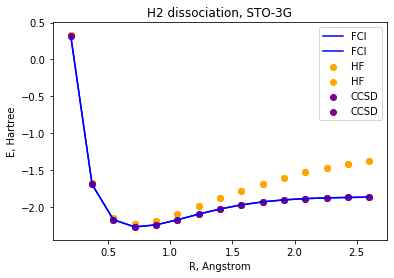

In [20]:
#Plot H2 PESs

plt.title('H2 dissociation, STO-3G')
plt.xlabel('R, Angstrom')
plt.ylabel('E, Hartree')

plt.plot(bond_lengths, FCI_PES_far_100, label='FCI', color='blue')
plt.plot(bond_lengths, 2*FCI_PES, label='FCI', color='blue')
plt.scatter(bond_lengths, HF_PES_far_100, label='HF', color='orange')
plt.scatter(bond_lengths, 2*HF_PES, label='HF', color='orange')
plt.scatter(bond_lengths, CCSD_PES_far_100, label='CCSD', color='purple')
plt.scatter(bond_lengths, 2*CCSD_PES, label='CCSD', color='purple')
plt.legend()

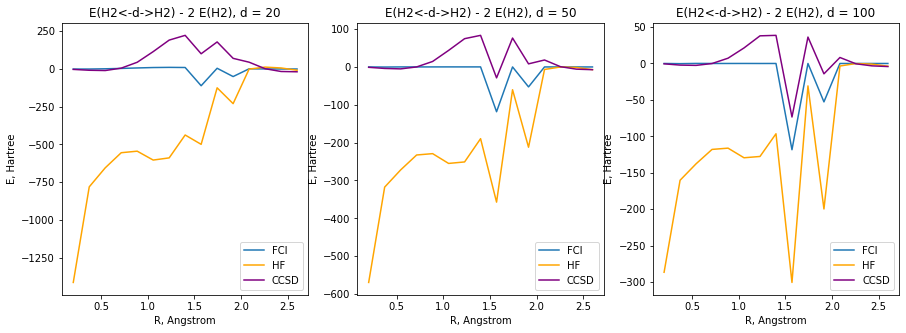

In [22]:
#Plot H2 PESs
scale=10**9

plt.figure(figsize=(15,5))

title = 'E(H2<-d->H2) - 2 E(H2), '

plt.subplot(1,3,1)
plt.plot(bond_lengths, (FCI_PES_far_020-2*FCI_PES)*scale, label='FCI')
plt.plot(bond_lengths, (HF_PES_far_020-2*HF_PES)*scale, label='HF', color='orange')
plt.plot(bond_lengths, (CCSD_PES_far_020-2*CCSD_PES)*scale, label='CCSD', color='purple')
plt.title(title + 'd = 20')
plt.xlabel('R, Angstrom')
plt.ylabel('E, Hartree')
plt.legend()

plt.subplot(1,3,2)
plt.plot(bond_lengths, (FCI_PES_far_050-2*FCI_PES)*scale, label='FCI')
plt.plot(bond_lengths, (HF_PES_far_050-2*HF_PES)*scale, label='HF', color='orange')
plt.plot(bond_lengths, (CCSD_PES_far_050-2*CCSD_PES)*scale, label='CCSD', color='purple')
plt.title(title + 'd = 50')
plt.xlabel('R, Angstrom')
plt.ylabel('E, Hartree')
plt.legend()

plt.subplot(1,3,3)
plt.plot(bond_lengths, (FCI_PES_far_100-2*FCI_PES)*scale, label='FCI')
plt.plot(bond_lengths, (HF_PES_far_100-2*HF_PES)*scale, label='HF', color='orange')
plt.plot(bond_lengths, (CCSD_PES_far_100-2*CCSD_PES)*scale, label='CCSD', color='purple')
plt.title(title + 'd = 100')
plt.xlabel('R, Angstrom')
plt.ylabel('E, Hartree')
plt.legend()

TODO
change unit on y label
add CISD

# LiH

E = -4.041729928511248 Eh
E = -6.476001431266474 Eh
E = -7.178193643340489 Eh
E = -7.526498486565391 Eh
E = -7.712630400158973 Eh
E = -7.809958142660568 Eh
E = -7.858103655150282 Eh
E = -7.878453652319019 Eh
E = -7.882668558604159 Eh
E = -7.877535303598006 Eh
E = -7.86726186399658 Eh
E = -7.854568284484584 Eh
E = -7.841269334302725 Eh
E = -7.828604512640165 Eh
E = -7.8173999273756625 Eh
E = -3.999938081850282 Eh
E = -6.442865006638948 Eh
E = -7.157727610056979 Eh
E = -7.507561971836502 Eh
E = -7.69493922797108 Eh
E = -7.793148010030828 Eh
E = -7.84129823610769 Eh
E = -7.86062131505413 Eh
E = -7.862747581116303 Eh
E = -7.854432789114544 Eh
E = -7.839814773080818 Eh
E = -7.821502044433597 Eh
E = -7.801168740856861 Eh
E = -7.779919081959606 Eh
E = -7.758519166159427 Eh
E = -4.04162633762092 Eh
E = -6.475814567885648 Eh
E = -7.178151795208303 Eh
E = -7.526489297627454 Eh
E = -7.712624094698165 Eh
E = -7.809951465614481 Eh
E = -7.8580960299230584 Eh
E = -7.878444199417256 Eh
E = -7.88265668

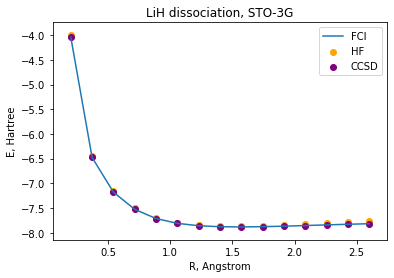

In [23]:
#Run FCI
FCI_PES = obtain_PES(['lih'], bond_lengths, basis, method='fci');
#Run HF
HF_PES = obtain_PES(['lih'], bond_lengths, basis,  method='hf');
#Run CCSD
CCSD_PES = obtain_PES(['lih'], bond_lengths, basis,  method='ccsd');
#Plot H2 PESs

plt.title('LiH dissociation, STO-3G')
plt.xlabel('R, Angstrom')
plt.ylabel('E, Hartree')

plt.plot(bond_lengths, FCI_PES, label='FCI')
plt.scatter(bond_lengths, HF_PES, label='HF', color='orange')
plt.scatter(bond_lengths, CCSD_PES, label='CCSD', color='purple')
plt.legend()

## H<sub>2</sub>O symmetric O-H dissociation

In [10]:
bond_lengths = np.linspace(0.5,2.7,15)

In [11]:
#Run FCI
FCI_PES = obtain_PES(['h2o'], bond_lengths, basis, method='fci')

Could not converge


In [9]:
#Run HF
HF_PES = obtain_PES('h2o', bond_lengths, basis,  method='hf')

E = -73.1294816132027 Eh
E = -74.45343797012882 Eh
E = -74.87055361048274 Eh
E = -74.96308510923824 Eh
E = -74.92817508739554 Eh
E = -74.84281942863745 Eh
E = -74.74051950148719 Eh
E = -74.63577758413565 Eh
E = -74.5357663865733 Eh
E = -74.4449438474384 Eh
E = -74.36975504261737 Eh
E = -74.29778481417816 Eh
E = -74.24167220051008 Eh
E = -74.27129957697417 Eh
Could not converge


In [10]:
#Run CCSD
CCSD_PES = obtain_PES('h2o', bond_lengths, basis,  method='ccsd')

E = -73.1427636391869 Eh
E = -74.47519485717146 Eh
E = -74.90406353010555 Eh
E = -75.01370018934803 Eh
E = -75.00330155818891 Eh
E = -74.95116757042632 Eh
E = -74.89128367467832 Eh
E = -74.8385340113911 Eh
E = -74.80070162375995 Eh
E = -74.78105738717322 Eh
E = -74.74394274756116 Eh
E = -74.77972801511778 Eh
E = -74.78338963453125 Eh
E = -74.64224434263167 Eh
Could not converge


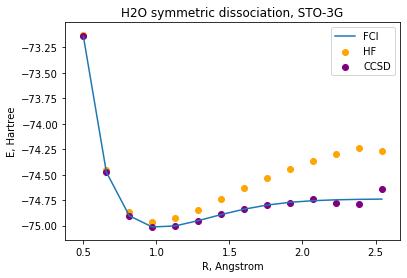

In [15]:
#Plot H2O PESs

plt.title('H2O symmetric dissociation, STO-3G')
plt.xlabel('R, Angstrom')
plt.ylabel('E, Hartree')

plt.plot(bond_lengths, FCI_PES, label='FCI')
plt.scatter(bond_lengths, HF_PES, label='HF', color='orange')
plt.scatter(bond_lengths, CCSD_PES, label='CCSD', color='purple')
plt.legend()